In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matlab.engine # to run Cheng's code
import os

# add the path to my packages to system paths so they can be imported
import sys
sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages')
# sys.path.append('F:\MAScThesis\code\my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

import dataprocess.data_handler_03 as dh
import assessment.assess_simgraph_10_cvxlmnn_gdpalmnn as asg
import simgraph.my_simgraph_06 as sg

# Load and group neuron spike data

In [2]:
# load all spike data from file
spikes_dp = '../../data/original_files/spikes.csv'
binned_data = np.loadtxt(spikes_dp, delimiter=',')
binned_data = binned_data.reshape(binned_data.shape[0], 1141, 113)
binned_data = binned_data * 2 - 1     # turn labels from 0,1 to -1,1

I_order_10 = [54, 35, 10, 60, 74, 9, 61, 56, 91, 104]

# group all neurons together
grouped_data = np.zeros((297, 1141, 1))
for trial in range(297):
    for frame in range(1141):
        grouped_data[trial, frame, :] = 2 * int((binned_data[trial, frame, :] == 1).any()) - 1

# Check the dataset

In [3]:
def get_mnist_labels(data_params):
    return np.loadtxt(data_params['features_dp']+'lbls.csv')

def transform_mnistsift(fv):
    return fv[::4]

def transform_slowfast(fv):
    """
    Transform to be applied on feature vectors.
    
    Input: fv
    fv - 1xDf torch tensor representing a feature vector
    
    Output: fvv
    fvv - 1xDf' torch tensor representing the transformed feature vector
    """
    
    # for faster run and less memory usage
    fvv = fv[::100]
    
    # for numerical stability during GD
    # fvv = fvv * 10
    
    return fvv

def transform_sift3d(fv):
    return fv[::50]

def transform_parham(fv):
    return fv[::5]

# data retrieval params
# data_params = {'func': dh.datapoint_sift, 'lbl_func': get_mnist_labels, 'features_dp': '../../data/fe_exp/mnist-sift/', \
#                'spike_data': None, 'group_id': None, 'transform': transform_mnistsift, 'ind_min': 0, 'ind_max': 13203, 'feature_id':'mnist-sift'}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/slowfast/slowfast_4732_numpy/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_slowfast, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'slowfast'}

data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/sift3d/fvs_s1/', \
               'spike_data': grouped_data, 'group_id': 0, 'transform': transform_sift3d, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'sift3d'}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/parham/parham3/features_2layer/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_parham, 'ind_min': 1*1141+41, 'ind_max': 2*1141-1, 'feature_id':'parham'}

In [4]:
train_num =10
val_num = 5

train_num, val_num, train_data, val_data = \
dh.random_train_val_balanced(train_num, val_num, data_params, seed=1342)

# show statistics
print('feature_id: ', data_params['feature_id'])
print('train_num = ', train_num, ', val_num = ', val_num)
print('number of features: ', train_data['des'].shape[1])
print('training data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(train_data['lbls'] == 1), np.sum(train_data['lbls'] == 1)*100/train_num))
print('validation data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(val_data['lbls'] == 1), np.sum(val_data['lbls'] == 1)*100/val_num))
print('train_smpls = ', train_data['smpls'], '\nval_smpls = ', val_data['smpls'])
print('train_lbls = ', train_data['lbls'], '\nval_lbls = ', val_data['lbls'])
print('train_des = ', train_data['des'], '\nval_des = ', val_data['des'])

feature_id:  sift3d
train_num =  10 , val_num =  5
number of features:  16
training data contains 5 points (50.00%) of label 1.
validation data contains 2 points (40.00%) of label 1.
train_smpls =  [2257 1637 1436 1899 1371 2279 2226 1629 1333 2064] 
val_smpls =  [2261 1639 1991 1247 1847]
train_lbls =  [ 1.  1.  1.  1.  1. -1. -1. -1. -1. -1.] 
val_lbls =  [ 1.  1. -1. -1. -1.]
train_des =  [[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  4.92500e-03 9.69000e-04 8.53320e-02 8.53320e-02 8.53320e-02 8.53320e-02
  4.90000e-05 3.00000e-05 1.43000e-04 3.71000e-04]
 [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  3.86310e-02 4.65390e-02 0.00000e+00 2.20000e-04 1.06749e-01 6.24940e-02
  0.00000e+00 2.80700e-03 1.06749e-01 1.06749e-01]
 [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  9.00000e-05 2.00750e-02 0.00000e+00 2.67000e-04 6.51640e-02 1.55480e-02
  0.00000e+00 2.16400e-03 9.67550e-02 1.82400e-02]
 [0.0000

# Assess the model's performance with random tests

In [10]:
# graph construction parameters (for both lmnn and obj1)
sg_params = {'Dt': 8, 'Dv':4, 'Dvt':8, \
             'cnstr_method_tt': 'halftime-lmnn', 'cnstr_method_vv': 'time-obj1', 'cnstr_method_vt': 'time',\
             'train_t': None, 'val_t': None, \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# training objective parameters (for both lmnn and obj1)
gamma = 1
beta = 1

# randomization parameters
rnd_params = {'train_sizes': [5, 10, 15, 20], 'val_sizes': [30], 'train_its': 3, 'val_its': 5, 'seed': None}

# parameters to visualize the optimized M
f_sz = train_data['des'].shape[1] # must match data_params
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
fig_params = {'rmark_th': 5, 'f_sz': f_sz, 'xloc': xloc, 'yloc': yloc}

# swap path for matlab's use
swap_path_jupyter = '../../data/fe_exp/cheng_swap_1/'  # relative to this notebook's current location
swap_path_matlab = '../../../data/fe_exp/cheng_swap_1/'  # relative to the matlab's working folder, not this notebook's current location

# path to save the results
# CRITICAL: clear the temp folder before running; otherwise crashes
res_path_cvx = '../../data/experiments/comparison/temp/cvx/'
res_path_gdpa = '../../data/experiments/comparison/temp/gdpa/'

In [6]:
# start matlab engine
eng = matlab.engine.start_matlab()
eng.cd(r'../15_cheng/lmnn-offtheshelf/', nargout=0)

In [11]:
val_num_res_sg, val_num_err_sg, val_num_res_lgrg, val_num_err_lgrg = asg.assess_sg_model(eng, gamma, beta, data_params, sg_params, rnd_params, fig_params, swap_path_jupyter, swap_path_matlab, res_path_cvx, res_path_gdpa)

-> Iteration ID:  30_5_0
Elapsed time is 0.051861 seconds.
Elapsed time is 0.034316 seconds.
n_delta = 9
Elapsed time is 0.025898 seconds.
 
Calling SeDuMi 1.3.4: 154 variables, 9 equality constraints
------------------------------------------------------------
SeDuMi 1.3.4 by AdvOL, 2005-2008 and Jos F. Sturm, 1998-2003.
Alg = 2: xz-corrector, Adaptive Step-Differentiation, theta = 0.250, beta = 0.500
eqs m = 9, order n = 35, dim = 275, blocks = 2
nnz(A) = 691 + 0, nnz(ADA) = 81, nnz(L) = 45
 it :     b*y       gap    delta  rate   t/tP*  t/tD*   feas cg cg  prec
  0 :            4.51E+00 0.000
  1 :   7.44E+00 9.25E-01 0.000 0.2053 0.9000 0.9000   2.40  1  1  4.4E-01
  2 :   7.87E+00 5.04E-01 0.000 0.5451 0.9000 0.9000   0.94  1  1  2.7E-01
  3 :   4.84E+00 2.33E-01 0.000 0.4626 0.9000 0.9000  -0.11  1  1  4.3E-01
  4 :   3.13E+00 5.88E-02 0.000 0.2521 0.9000 0.9000   0.51  1  1  1.7E-01
  5 :   2.40E+00 2.97E-02 0.000 0.5051 0.9000 0.9000   0.47  1  1  9.8E-02
  6 :   1.42E+00 1.20E

In [12]:
cvx_title = '{}, Dt = {}, Dvt = {}, Dv = {}, gamma = {}, beta = {}'.format(data_params['feature_id'], sg_params['Dt'], sg_params['Dvt'], sg_params['Dv'], gamma, beta)
gdpa_title = '{}, Dt = {}, Dvt = {}, Dv = {}, gamma = {}, beta = {}'.format(data_params['feature_id'], sg_params['Dt'], sg_params['Dvt'], sg_params['Dv'], gamma, beta)

In [13]:
asg.plot_curves(rnd_params, cvx_title, res_path_cvx)

In [14]:
asg.plot_curves_2(rnd_params, gdpa_title, res_path_gdpa)

In [15]:
# close the matlab engine when you're done
eng.quit()

# Plot cvx-lmnn and gdpa validation accuracies together

In [16]:
def read_train_curves(val_sizes, res_path):
    assess_qs = ['min_acc', 'val_acc', 'missed', 'false_alarm']
    curves = {}
    errors = {}
    for i in range(len(val_sizes)):
        curves_i = np.loadtxt(res_path+'curves/train_'+str(i)+'.txt')
        j = 0
        for quantity in assess_qs:
            if i==0:
                curves[quantity] = curves_i[j::8].reshape((1, -1))
                errors[quantity] = curves_i[j+1::8].reshape((1, -1))
            else:
                curves[quantity] = np.concatenate((curves[quantity], [curves_i[j::8]]), axis=0)
                errors[quantity] = np.concatenate((errors[quantity], [curves_i[j+1::8]]), axis=0)
            j += 2
            
        return curves, errors

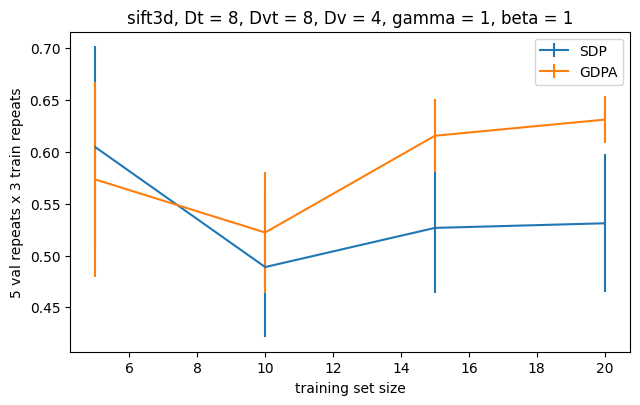

In [17]:
res_path_1 = res_path_cvx
res_path_2 = res_path_gdpa
legend = ['SDP', 'GDPA']
title =  cvx_title

# unpack params
train_sizes = rnd_params['train_sizes']
val_sizes = rnd_params['val_sizes']
train_its = rnd_params['train_its']
val_its = rnd_params['val_its']

# read training curves
curves_1, errors_1 = read_train_curves(val_sizes, res_path_1)
curves_2, errors_2 = read_train_curves(val_sizes, res_path_2)

# plot training curves
plt.figure(figsize=(7,4))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.8,hspace=0.8)
for i in range(len(val_sizes)):
    plt.subplot(len(val_sizes), 1, i+1)
    plt.errorbar(train_sizes, curves_1['val_acc'][i], errors_1['val_acc'][i])
    plt.errorbar(train_sizes, curves_2['val_acc'][i], errors_2['val_acc'][i])
    plt.legend(legend)
    plt.xlabel('training set size')
    plt.ylabel('{} val repeats x {} train repeats'.format(val_its, train_its))
    _ = plt.title(title)
# splt.savefig(res_path_4+'benchmark.png')

# Plot train losses together

In [18]:
def read_loss_curves(val_sizes, res_path):
    for i in range(len(val_sizes)):
        curves_i = np.loadtxt(res_path+'curves/trainloss_'+str(i)+'.txt')
        if i==0:
            curves = curves_i[::2].reshape((1, -1))
            errors = curves_i[1::2].reshape((1, -1))
        else:
            curves = np.concatenate((curves, [curves_i[::2]]), axis=0)
            errors = np.concatenate((errors, [curves_i[1::2]]), axis=0)
    
    return curves, errors

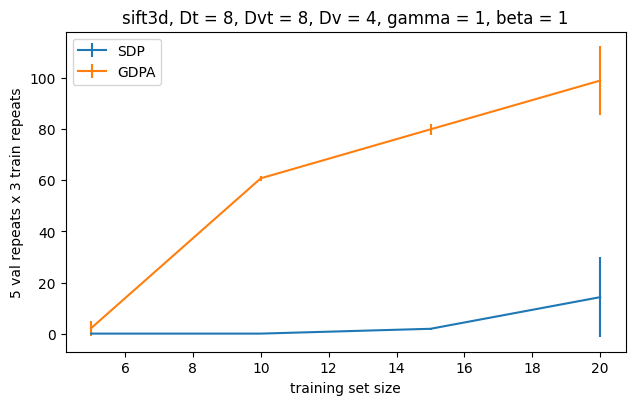

In [19]:
# read training curves
curves_1, errors_1 = read_loss_curves(val_sizes, res_path_1)
curves_2, errors_2 = read_loss_curves(val_sizes, res_path_2)

# plot training curves
plt.figure(figsize=(7,4))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.8,hspace=0.8)
for i in range(len(val_sizes)):
    plt.subplot(len(val_sizes), 1, i+1)
    plt.errorbar(train_sizes, curves_1[i], errors_1[i])
    plt.errorbar(train_sizes, curves_2[i], errors_2[i])
    plt.legend(legend)
    plt.xlabel('training set size')
    plt.ylabel('{} val repeats x {} train repeats'.format(val_its, train_its))
    _ = plt.title(title)
# splt.savefig(res_path_4+'benchmark.png')